### Coastal filling to make product global
Use this code if you would like to fill in the coastal areas with a scaled climatology as done in SeaFlux. Other options are to make the product without any coastal filling.

Same approach as used in Seaflux (Fay & Gregor et al. 2021), but instead of the ensemble of products, scale the climatology (Landschutzer et al. 2020) only to the overlapping open ocean areas of this product and the climatology.

In [1]:
import pickle
import os
import scipy
from scipy import stats
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import xarray as xr
import datetime
import matplotlib.dates as mdates

from numpy import errstate,isneginf,array
import yaml

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots

In [2]:
global_vars = yaml.safe_load(open('../config.yml', 'r') )

data_folder_root = global_vars['download_folder']

'/data/artemis/workspace/afay/LDEO_HPD/data/'

In [5]:
ds = xr.open_dataset(f"{data_folder_root}/pCO2/processed/MPI_ULB_SOMFFN_coastal_clim_fco2_200601-200612.nc")

coastal_clim_fco2 = ds.fco2


In [9]:
#load in our most recent product
final_result_folder = global_vars['hpd_save_folder']

ds = xr.load_dataset(f"{final_result_folder}/GCB_2024/HPD_pCO2_cc2000s_1x1_recon_1959-2023.nc")
hpd = ds['HPD_pCO2_back_in_time'] #tehcnically this is in fco2!

In [9]:
# Dates of Reconstruction 
# date_range_start = '1959-01-01T00:00:00.000000000'
date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2023-12-01T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

# Dates of Reconstruction for back intime
# date_range_start = '1959-01-01T00:00:00.000000000'
date_range_start_back_time_time = '1959-01-01T00:00:00.000000000'

# create date vector
dates_back_in_time = pd.date_range(start=date_range_start_back_time_time, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

yr_end = 2023

In [10]:
coastal_long = np.empty(shape=(dates_back_in_time.size,180,360))

#assigning the coastal clim to all years repeating. will scale below.

for y in range(0,(yr_end-1959)+1):
        coastal_long[(y)*12:((y+1)*12),:,:] = coastal_clim_fco2[0:12,:,:]#clim_corr_1998_2022[m,:,:,:] + dm[f"{mod}"].sel(time=slice(f"{yr}-01-01",f"{yr}-12-31"))

In [12]:
#make into a data array/dataset

coastal_long_out = xr.Dataset(  {
                        # 'pco2':(["time","ylat","xlon"],pco2.data),
                        'coastal_long':(["time","lat","lon"],coastal_long.data)
                        },
                        coords={'time': (['time'],dates_back_in_time),
                          'lat': (['lat'],coastal_clim_fco2.ylat.data),
                          'lon': (['lon'],coastal_clim_fco2.xlon.data)}
                    )
coastal_long_out.coastal_long.attrs['description'] = 'landschutzer coastal full climatology, repeated/expanded to all years, in fco2'
coastal_long_out.coastal_long.attrs['units'] = 'uatm'


In [14]:
#global area weighted version
weights = np.cos(np.deg2rad(hpd.lat))
weights.name = "weights"

scaling = (hpd/coastal_long_out.coastal_long).mean(['lon','lat']) #need to do this in a weighted version for global-area weighting.
scaling_weighted = (hpd/coastal_long_out.coastal_long).weighted(weights).mean(['lon','lat']) 



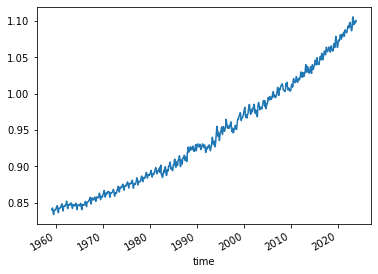

In [15]:
scaling_weighted.plot()

In [1]:
coastal_full = coastal_long_out.coastal_long*scaling_weighted
# print(coastal_full)

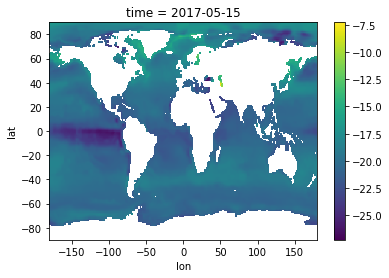

In [19]:
#just to confirm that it's looking right. 
#if you do a month like #100 then it shoul dbe mostly positive and then if you do a month like #650, it should be mostly negative
d = coastal_long_out.coastal_long[700,:,:] - coastal_full[700,:,:]
d.plot()

### fill in missing spots in recon_pCO2 with this coastal_full

In [18]:

hpd_filled = hpd.fillna(coastal_full)

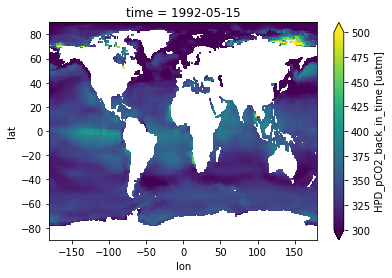

In [24]:
hpd_filled[400,:,:].plot(vmin=300,vmax=500)

In [31]:
#save JUST the coastal filling file here

out_folder = global_vars['reconstruction_folder']

coastal_out = xr.Dataset(  {
                        # 'pco2':(["time","ylat","xlon"],pco2.data),
                        'coastal_clim_scaled':(["time","lat","lon"],coastal_full)
                        },
                        coords={'time': (['time'],dates_back_in_time), #.values
                          'lat': (['lat'],coastal_clim_fco2.ylat.data),
                          'lon': (['lon'],coastal_clim_fco2.xlon.data)}
                    )
coastal_out.coastal_clim_scaled.attrs['description'] = 'landschutzer coastal full climatology, expanded to all years, in fco2 using a scaling factor from HPD back in time'
coastal_out.coastal_clim_scaled.attrs['units'] = 'uatm'

coastal_out.attrs['title']="Coastal Clim fCO2 back in time"
coastal_out.attrs['notes']="see methods in SeaFlux ESSD paper to learn how to do this"
coastal_out.attrs['notes2']="converted the original pCO2 to fCO2 for use in GCB method"
coastal_out.attrs['history']="Run by AFay"
coastal_out.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
coastal_out.attrs['references']="/home/afay/LDEO_HPD/devans_code/06_coastal_filling.ipynb"
coastal_out.attrs['date_created']=str(datetime.datetime.now())
coastal_out.to_netcdf(f'{out_folder}/Coastal_clim_HPD_backintime_1959_2023.nc') 

In [35]:
# Save HPD with coastal filling here
# Create DataSets and Write out NETCDFs for Reconstructed pCO2:

final_result_folder = global_vars['hpd_save_folder']
# recon_output_dirAF = "/data/artemis/workspace/afay/LDEO_HPD/models/XGB/GCB_2022"


ds3_out = xr.Dataset({
                        'HPD_filled':(["time","lat","lon"],hpd_filled)},

                        coords={
                       
                        'time': (['time'],dates_back_in_time),
                        'lat': (['lat'],hpd_filled.lat),
                        'lon':(['lon'],hpd_filled.lon)})
        
# Save to netcdf
ds3_out['HPD_filled'].attrs['description'] = "coastal filling done using method from Seaflux and Landschutzer et al 2020 for scaling"
ds3_out['HPD_filled'].attrs['description2'] = "back in time: Mean of model corr recons, clim of corr (2000-end) used for pCO2 prior to 1982"
ds3_out['HPD_filled'].attrs['units'] = "uatm"

ds3_out.attrs['title']="LDEO-HPD Back in time, Filled"
ds3_out.attrs['history']="XGBoost results, Clim Corrections, and filling by AFay"
ds3_out.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
# ds3_out.attrs['references']="/home/afay/LDEO_HPD/Back_in_Time/recon_pCO2_CO2flux_v2022.ipynb"
ds3_out.attrs['references']="/home/afay/LDEO_HPD/devans_code/05_Produce_product_back_in_time.ipynb"
ds3_out.attrs['date_created']=str(datetime.datetime.now())
ds3_out.to_netcdf(f'{final_result_folder}/GCB_2024/HPD_pCO2_cc2000s_1x1_recon_1959-2023_filled.nc') 